In [1]:
#7/6/24 For the implementation of K-fold testing with Random Forests onto the mutagen fingerprint data
#5 fold split, 4 train with the last fold being split into 2 for validation/testing
#After this is done will apply the process onto other models

#In total:
#The intial data is split into 80/20 for train/validation
#The training set is then split into 5 folds
#Each fold acts as a test/validation split for the other folds to predict on as training
#This results in 5 models
#The models then each predict onto the final validation set
#A consensus of each models prediction is taken and metrics from that are calculated

#Split tracking:
#From 100% total data: 80/20 initial split (train/validation)
#From 80% trainset: 16/16/16/16/16 Folds split 
    #For each fold: 64/8/8 train/test/valid splits for model training
    #The models are trained on the train set to be optimized for the test set and validated on the validation set
    #results in 5 models
#From 20% initial validation set
    #each model is tested
    #consensus (most popular result) is reached
#Net model is created

import pandas as pd
import numpy as np
import math
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#Data import
targetdata = pd.read_csv('/Users/james/Documents/Honours/Data/Targetdata/mutagen/mutDrugTargets.csv')
smilesdropped = targetdata.drop(columns=['SMILES'])

#Splitting data into 5 folds 
dfarray = smilesdropped.to_numpy()
#First set aside 20% of the data for a final validation at the end
dfarray, tempset = train_test_split(dfarray, test_size=0.2, random_state=82)

size = len(dfarray) / 5
splitsize = math.ceil(size)
empty = [[] for _ in range(5)]
splits = []
for list in empty:
    splits.append(list)

loops = 0
currsplit = 0
#Results in a list of 5 lists that each contain 1/5 of the targetdata
for row in dfarray:
    splits[currsplit].append(row)
    if loops == splitsize:
        loops = 0
        currsplit = currsplit + 1
    loops = loops + 1

folds = []
for split in splits:
    temp = pd.DataFrame(split)
    folds.append(temp)

In [2]:
targetdata

,SMILES,Toxicity_Values,"('CHEMBL3959',)","('CHEMBL4478',)","('CHEMBL1944495',)","('CHEMBL3048',)","('CHEMBL2902',)","('CHEMBL5141',)","('CHEMBL1968',)","('CHEMBL5896',)",...,"('CHEMBL319',)","('CHEMBL1907591',)","('CHEMBL4777',)","('CHEMBL4508',)","('CHEMBL1941',)","('CHEMBL2163176',)","('CHEMBL1795101',)","('CHEMBL2424',)","('CHEMBL2434',)","('CHEMBL5113',)"
0,OC[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,OCC(O)CO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,O=[N+]([O-])OCC(CO[N+](=O)[O-])O[N+](=O)[O-],1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,FC(F)(F)C(Cl)Br,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,FC(F)OC(Cl)C(F)(F)F,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7480,c1cc2c3c(cccc3c1)[C@H]1N[C@@H]21,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7481,c1cc2sncc2cc1OC[C@H]1CO1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7482,c1ccc2c(c1)ccc1cc3ccc4ccccc4c3cc12,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7483,c1ccc2c3c4c(cc5ccccc5c4cc2c1)[C@@H]1O[C@H]31,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [3]:
#function to calculate various metrics, outputs a list of various metrics with a consistent index
def metriccalc(preds, ytrain):
    correctcount = 0
    fpcount = 0
    tpcount = 0
    tncount = 0
    fncount = 0
    testpos = 0
    testneg = 0
    
    #loop through each item in the predictions, logging positives, negatives and tn/tp/fn/tp
    iterations = 0
    for value in preds:
        testscore = ytrain[iterations]
        if value == 1:
            if testscore != 0:
                testpos = testpos + 1
                correctcount = correctcount + 1
                tpcount = tpcount + 1
            else:
                fpcount = fpcount + 1
                testneg = testneg + 1
        else:
            if testscore != 0:
                testpos = testpos + 1
                fncount = fncount + 1
            else:
                testneg = testneg + 1
                correctcount = correctcount + 1
                tncount = tncount + 1

        iterations = iterations + 1
    
    #calculate a wide swathe of metrics
    netfn = fncount / (fncount + tncount)
    nettn = tncount / (fncount + tncount)
    netacc = correctcount / (fpcount + fncount + tpcount + tncount)
    posacc = tpcount / testpos
    negacc = tncount / testneg
    netfp = fpcount / (fpcount + tpcount)
    nettp = tpcount / (tpcount + fpcount)

    fpr = fpcount / (fpcount + tncount)
    tpr = tpcount / (tpcount + fncount)



    f1 = (2 * tpcount) / ((2 * tpcount) + fpcount + fncount)


    tp = tpcount
    fp = fpcount
    tn = tncount
    fn = fncount

    
    temp = math.sqrt((fp + tn) * (tp + fp) * (tp + fn) * (tn + fn))
    if temp == 0:
        return 0
    mcc = ((tp * tn) - (fp * fn)) / temp



    temp = (( ( (tp + fp) * (fp + tn) ) + ( (tp + fn) * (fn + tn) ) ))
    if temp == 0:
        return 0
    kapp =  ( 2 * ((tp * tn) - (fn * fp)) ) / temp
    
    metriclist = [testpos, testneg, fn, tn, tp, fp, netacc, posacc, negacc, fpr, tpr, f1, mcc, kapp]
    
    return metriclist

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


for fold 1 best mcc of 0.06730955402458903 with an mtry of 10


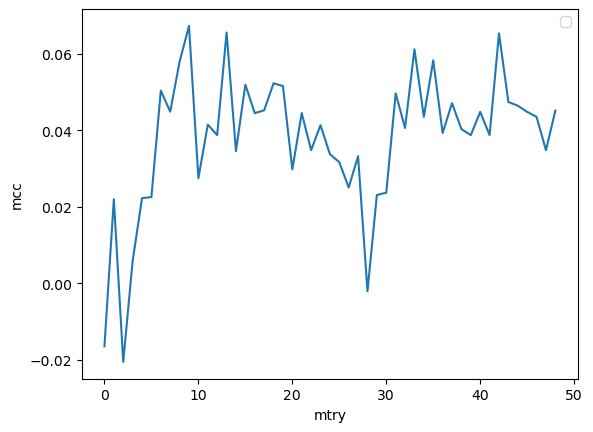

validation metrics of:
positives in data 349
negatives in data 251 

fn count = 156
tn count = 126
tp count = 193
fp count = 125 

net accuracy = 0.5316666666666666
positive accuracy = 0.5530085959885387
negative accuracy = 0.50199203187251 

fpr = 0.49800796812749004
tpr = 0.5530085959885387 

f1 score = 0.5787106446776612
mcc = 0.05435995734632097
cohen Kappa = 0.0540631522251397


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


for fold 2 best mcc of 0.02794441733261128 with an mtry of 2


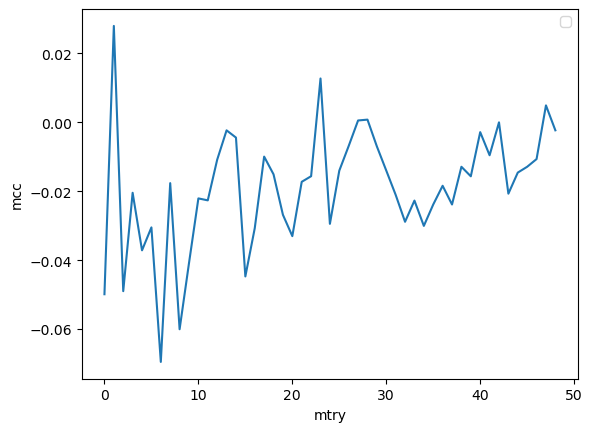

validation metrics of:
positives in data 337
negatives in data 262 

fn count = 215
tn count = 168
tp count = 122
fp count = 94 

net accuracy = 0.48414023372287146
positive accuracy = 0.3620178041543027
negative accuracy = 0.6412213740458015 

fpr = 0.35877862595419846
tpr = 0.3620178041543027 

f1 score = 0.4412296564195298
mcc = 0.0033463716667100065
cohen Kappa = 0.0030808507887947517


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


for fold 3 best mcc of 0.05965722472859563 with an mtry of 12


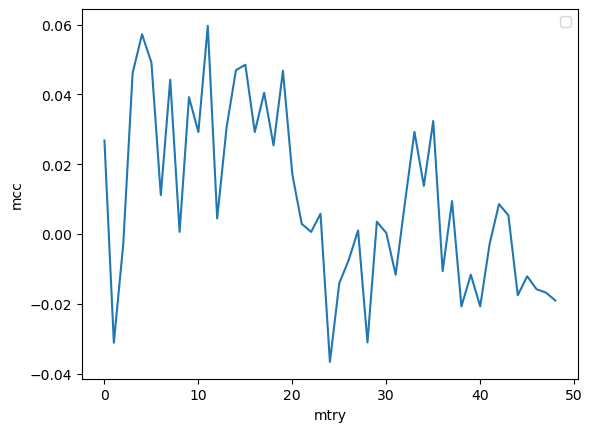

validation metrics of:
positives in data 339
negatives in data 260 

fn count = 139
tn count = 124
tp count = 200
fp count = 136 

net accuracy = 0.5409015025041736
positive accuracy = 0.5899705014749262
negative accuracy = 0.47692307692307695 

fpr = 0.5230769230769231
tpr = 0.5899705014749262 

f1 score = 0.5925925925925926
mcc = 0.06680722594908549
cohen Kappa = 0.06680376394341621


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


for fold 4 best mcc of 0.06734346587668981 with an mtry of 40


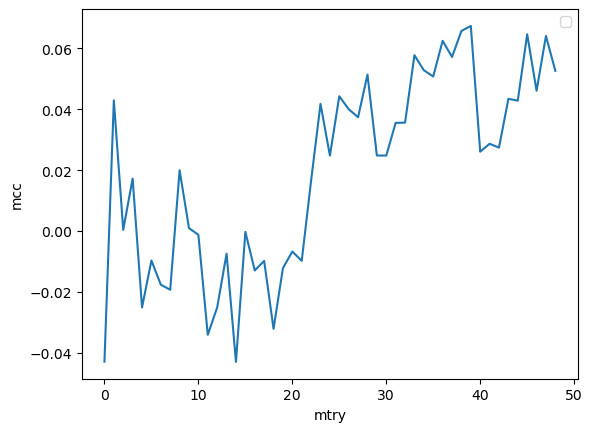

validation metrics of:
positives in data 342
negatives in data 257 

fn count = 126
tn count = 83
tp count = 216
fp count = 174 

net accuracy = 0.4991652754590985
positive accuracy = 0.631578947368421
negative accuracy = 0.3229571984435798 

fpr = 0.6770428015564203
tpr = 0.631578947368421 

f1 score = 0.5901639344262295
mcc = -0.04721069765891883
cohen Kappa = -0.04654413306310713


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


for fold 5 best mcc of 0.10213191755563565 with an mtry of 24


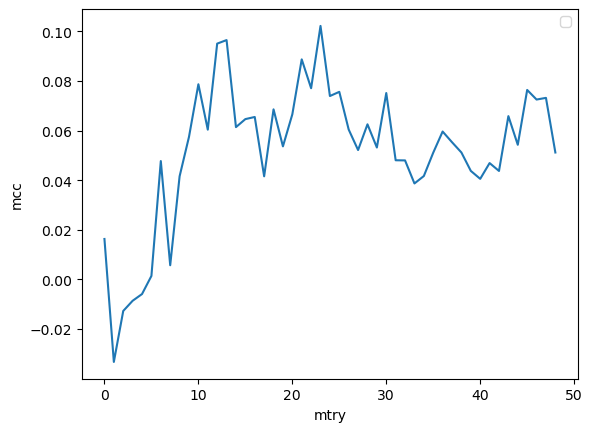

validation metrics of:
positives in data 330
negatives in data 268 

fn count = 113
tn count = 109
tp count = 217
fp count = 159 

net accuracy = 0.5451505016722408
positive accuracy = 0.6575757575757576
negative accuracy = 0.40671641791044777 

fpr = 0.5932835820895522
tpr = 0.6575757575757576 

f1 score = 0.6147308781869688
mcc = 0.06617776239824066
cohen Kappa = 0.06534580642195509


In [4]:
model_list = []
validlist = []
#For loop that uses each fold once for valid/testing and the rest for training
#Each 'split' in the range corresponds to the set used for test/validation with the other 4 for training
for split in range(0,5):
    #Set creation
    trainlist = [df for i, df in enumerate(folds) if i != split]
    trainset = pd.concat(trainlist, axis=0)
    testset, validset = train_test_split(folds[split], test_size=0.5, random_state=82)
    
    ytrain = trainset[0].values
    xtrain = trainset.iloc[:, 1:]
    
    ytest = testset[0].values
    xtest = testset.iloc[:, 1:]
    
    yvalid = validset[0].values
    xvalid = validset.iloc[:, 1:]
    
    #lists of metric values
    mcclist = []
    maxval = 0
    for mtry in range(1, 50):
        #using mtry as the adjusted hyperparameter creates a series of random forests
        rf = RandomForestClassifier(n_estimators=mtry, criterion='entropy', max_depth=None, 
                                min_samples_split=2, min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, max_features='sqrt', 
                                max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                bootstrap=True, oob_score=False, n_jobs= 4, random_state=81, 
                                verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

        model= rf.fit(xtrain, ytrain)
        preds = model.predict(xtest)
        #calculate metric (mcc)
        mcc = metriccalc(preds, ytest)[12]
        mcclist.append(mcc)
        if mcc > maxval:
            maxval = mcc
            bestmetrics = mtry
    #store best model for the given fold and plot the metric vs mcc value
    rf = RandomForestClassifier(n_estimators=bestmetrics, criterion='entropy', max_depth=None, 
                                min_samples_split=2, min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, max_features='sqrt', 
                                max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                bootstrap=True, oob_score=False, n_jobs= 4, random_state=81, 
                                verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
    model_list.append(rf)
    print('for fold', split + 1, 'best mcc of', maxval, 'with an mtry of', bestmetrics)
    plt.plot(mcclist)

    plt.xlabel('mtry')
    plt.ylabel('mcc')
    plt.legend()
    plt.show()
    
    #check models onto validation set, printing various metrics
    model= rf.fit(xtrain, ytrain)
    preds = model.predict(xvalid)
    results = metriccalc(preds, yvalid)
    validlist.append(results)
    print('validation metrics of:')
    print('positives in data', results[0])
    print('negatives in data', results[1], '\n')
    print('fn count =', results[2])
    print('tn count =', results[3])
    print('tp count =', results[4])
    print('fp count =', results[5], '\n')
    print('net accuracy =', results[6])
    print('positive accuracy =', results[7])
    print('negative accuracy =', results[8], '\n')
    print('fpr =', results[9])
    print('tpr =', results[10], '\n')
    print('f1 score =',results[11])
    print('mcc =',results[12])
    print('cohen Kappa =',results[13])


In [6]:
y = tempset[0]
x = tempset[:, 1:]
for model in model_list:
    predictions = []
    preds = model.predict(x)
    predictions.append(preds)
    
    metriccalc(preds, y)
    print('validation metrics of:')
    print('positives in data', results[0])
    print('negatives in data', results[1], '\n')
    print('fn count =', results[2])
    print('tn count =', results[3])
    print('tp count =', results[4])
    print('fp count =', results[5], '\n')
    print('net accuracy =', results[6])
    print('positive accuracy =', results[7])
    print('negative accuracy =', results[8], '\n')
    print('fpr =', results[9])
    print('tpr =', results[10], '\n')
    print('f1 score =',results[11])
    print('mcc =',results[12])
    print('cohen Kappa =',results[13])

IndexError: index 321 is out of bounds for axis 0 with size 321

In [13]:
print(len(preds))
print(len(ytrain))

1497
4793


In [ ]:
#get x and y values for the final validation set


toxvals = []
fingerprints = []
for row in tempset:
    toxvals.append(row[0])
    fingerprints.append(row[1:])

In [ ]:
#calculates consensus of models on each fingerprint in the final validation set
consensuslist = []
for fp in fingerprints:
    consensus = -1
    fp = fp.reshape(1, -1)
    #appends each model's prediction to a list
    predictions = []
    for model in model_list:
        preds = model.predict(fp)
        predictions.append(preds)
    #finds number of 0s in the prediction list
    zercount = 0
    for num in predictions:
        if num == 0:
            zercount = zercount + 1
    #as there are 5 models, if there are more than 2 0s predicted, the consensus is 1
    if zercount > 2:
        consensus = 1
    else:
        consensus = 0
    consensuslist.append(consensus)
#calculate and print metrics
results = metriccalc(consensuslist, toxvals)
print('validation metrics of:')
print('positives in data', results[0])
print('negatives in data', results[1], '\n')
print('fn count =', results[2])
print('tn count =', results[3])
print('tp count =', results[4])
print('fp count =', results[5], '\n')
print('net accuracy =', results[6])
print('positive accuracy =', results[7])
print('negative accuracy =', results[8], '\n')
print('fpr =', results[9])
print('tpr =', results[10], '\n')
print('f1 score =',results[11])
print('mcc =',results[12])
print('cohen Kappa =',results[13])

In [6]:
#oddly enough the consensus list produces almost the exact opposite of the correct predictions

In [7]:
#however, if we where to invert the consensus
loops = 0
for num in consensuslist:
    if num == 0:
        consensuslist[loops] = 1
    else:
        consensuslist[loops] = 0
    loops = loops + 1

In [8]:
results = metriccalc(consensuslist, toxvals)
print('validation metrics of:')
print('positives in data', results[0])
print('negatives in data', results[1], '\n')
print('fn count =', results[2])
print('tn count =', results[3])
print('tp count =', results[4])
print('fp count =', results[5], '\n')
print('net accuracy =', results[6])
print('positive accuracy =', results[7])
print('negative accuracy =', results[8], '\n')
print('fpr =', results[9])
print('tpr =', results[10], '\n')
print('f1 score =',results[11])
print('mcc =',results[12])
print('cohen Kappa =',results[13])

validation metrics of:
positives in data 815
negatives in data 682 

fn count = 118
tn count = 540
tp count = 697
fp count = 142 

net accuracy = 0.8263193052772211
positive accuracy = 0.8552147239263803
negative accuracy = 0.7917888563049853 

fpr = 0.20821114369501467
tpr = 0.8552147239263803 

f1 score = 0.8428053204353083
mcc = 0.6492078288012559
cohen Kappa = 0.64886672416344


In [9]:
#we get a very accurate and robust set of results